In [64]:
import rasterio
import cv2
import numpy as np

%matplotlib inline 
import matplotlib.pyplot as plt

import rasterio.warp

#from geojson import Feature, MultiPolygon, FeatureCollection
#import geojson

from affine import Affine
from pyproj import Proj, transform

from shapely.geometry import Point, Polygon, MultiPoint, box

import geopandas as gpd
import pandas as pd

import numpy as np
import os

from tqdm import tqdm

import glob

In [40]:
def old_latlon_to_ij(sample, crs, index):
    lat, lon = sample[0], sample[1]
    x, y = rasterio.warp.transform_geom('EPSG:4326', crs, {'type':'Polygon','coordinates':[[[lat, lon]]]}, precision=12)['coordinates'][0][0]
    i,j = map(int, index(x,y))
    return i,j

def latlon_to_ij(sample, crs, index):
    lat, lon = sample[0], sample[1]
    lat_longs = []
    for i in range(sample[0].shape[0]):
        lat_longs.append([sample[0][i], sample[1][i]])
    
    xys = rasterio.warp.transform_geom('EPSG:4326', crs, {'type':'Polygon','coordinates':[lat_longs]}, precision=12)['coordinates']
    ijs = []
    
    for xy in xys[0]:
        nxy = index(xy[0],xy[1])
        ijs.append([round(nxy[0]), round(nxy[1])])
        
    return ijs

def ij_to_latlon(sample, affine, crs):
    p1 = Proj(crs)
    T1 = affine * Affine.translation(0.5, 0.5)
    rc2en = lambda r, c: (c, r) * T1
    eastings, northings = np.vectorize(rc2en, otypes=[np.float, np.float])(sample[0], sample[1])
    p2 = Proj(proj='latlong',datum='WGS84')
    longs, lats = transform(p1, p2, eastings, northings)
    return longs, lats

# 

In [68]:
cities = os.listdir('../datasets/onera/train_labels/')



In [76]:
for city in cities:
    if 'txt' not in city:
        print (city)
        lmap = glob.glob('../datasets/onera/train_labels/' + city + '/cm/*.tif')[0]
        from_them = glob.glob('../datasets/onera/images/' + city + '/imgs_1/*_B02.tif')[0]
        safe = glob.glob('../datasets/onera/images/' + city + '/cropped_safes/*/B02.tif')[0]
        
        label = rasterio.open(lmap)
        them = rasterio.open(from_them)
        band = rasterio.open(safe)
        
        l = label.read()[0]
        b = band.read()[0]
        t = them.read()[0]
        
        o = np.zeros(b.shape)
        
        cons_locs = np.where(l == 2)
        cons_lls = ij_to_latlon(cons_locs, them.transform, them.crs)
        new_locs = latlon_to_ij(cons_lls, band.crs, band.index)
        for i in range(len(new_locs)):
            o[new_locs[i][0], new_locs[i][1]] = 1
            
        cv2.imwrite('../datasets/onera/train_labels/' + city + '/cm/new_' + city + '.png', o*255)


cupertino


/usr/local/lib/python3.5/dist-packages/rasterio/__init__.py:217: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, **kwargs)


bercy
abudhabi
hongkong
saclay_e
paris
nantes
aguasclaras
beihai
bordeaux
mumbai
beirut
pisa
rennes


In [5]:
label.shape, band.shape, them.shape

((799, 785), (852, 772), (799, 785))

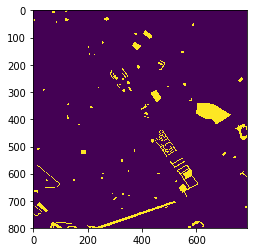

In [7]:
plt.imshow(l)

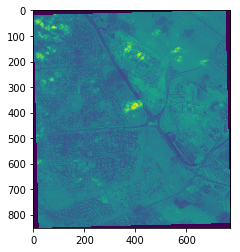

In [8]:
plt.imshow(b)

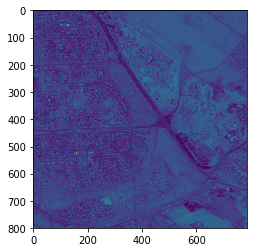

In [9]:
plt.imshow(t)

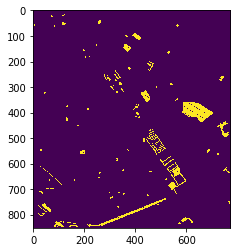

In [58]:
plt.imshow(o)